In [75]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [76]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self, x0 = 0):
        """
        Init class
        """
        assert (type(x0) == float or type(x0) == int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self, n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step) * self.x0
        
        for i in range(1, n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1] + (yi / np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step) * self.x0
        
        for i in range(1, n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1] + (yi / np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=0.68,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu - (sigma^2 / 2).t) + sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s

In [77]:
def plot_stock_price(s0, mu, sigma):
    """
    Plots stock price for multiple scenarios
    """
    plt.figure(figsize=(9,4))
    for i in range(5):
        plt.plot(b.stock_price(s0 = s0,
                               mu = mu,
                               sigma = sigma,
                               dt = 0.1))
    plt.legend(['Scenario-'+str(i) for i in range(1,6)],
               loc='upper left')
    plt.hlines(y=100, xmin=0, xmax=520,
               linestyle='--',color='k')
    plt.show()

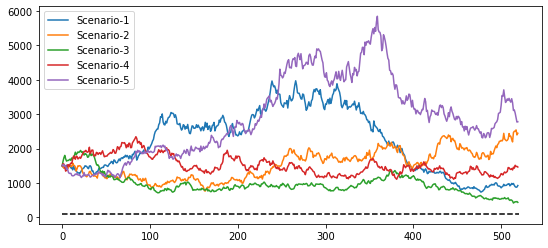

In [78]:
b = Brownian(1500)

sigma = .8
no_drift_mu = (sigma ** 2) / 2

plot_stock_price(s0 = 1500, mu=no_drift_mu, sigma=.8)

In [79]:
class CSMM:
    def __init__(self, _priceAperB, _fee, _rA, _rB):
        self.priceAperB = _priceAperB
        self.fee = _fee
        self.rA = _rA
        self.rB = _rB

    def maxSwap(self, _aforb):
        if _aforb:
            self.rA += self.rB * self.priceAperB / self.fee
            self.rB = 0
        else:
            self.rA += self.rB / (self.priceAperB * self.fee)
            self.rB = 0